## Imports and data generation

In [1]:
!pip install -r pip-requirements.txt

In [2]:
import warnings
warnings.filterwarnings("ignore") 
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from snowflake.sqlalchemy import URL
import os
import time
import datetime
import snowflake.connector
import string
# import seaborn as sns
import matplotlib.pyplot as plt
from jinja2 import Template
import sys
!{sys.executable} -m pip install pivottablejs

from pivottablejs import pivot_ui

snowflake_configuration = {
                            'url' : 'hg51401.snowflakecomputing.com',
                            'account' : 'hg51401',
                            'user':'cristhian.lozano@rappi.com',
                            'port' : 443,
                            'warehouse': 'AI',
                            'password' : 'd*XFiPQ3rGwn!92Lk*e4Fx9r',
                            'database' : 'fivetran'
                           }
engine = create_engine(URL(**snowflake_configuration))
connection = engine.connect()

In [3]:
#PARAMETERS FOR SNOWFLAKE 

#COUNTRY mx=Mexico ar=Argentina co=Colombia, etc
icountry = ["CO"]
# Select issue date and period of historical analisis for the forecast
# issue date in MONTH-DAY-YEAR  mm-dd-yy
#--------------------------
date = "05-27-21"
#--------------------------

#PARAMETERS SET
# set Calc type "canceled or active"
calc_type = "active"
seasonal= True
s_periods = 3
# Set forecast days and period for analisis
forecast_days=1
#day hours from 0 to 23 for hour_fin use hour_fin = hour_fin+1, to select one hour put the same number in both
hour_ini=13
hour_fin=13

# Select Vertical if orders were afected in just one vertical default vertical="all"
#vertical = ANTOJOS	CPGS	E-COMMERCE	OTROS	RAPPICASH	RAPPIFAVOR	RESTAURANTES	 ["Super","Farmacia","Express","Licores", "CPGs"]
#vertical = ["CPGS"]
vertical = "all"
#vertical = ["E-COMMERCE","CPGS"]
#vertical = ["RESTAURANTES"]
#vertical = ["E-COMMERCE"]

#DAY transformations
date2 = datetime.datetime.strptime(date, "%m-%d-%y")
idate = ((str(date2).split(':')[0]).split()[0])
end_date = date2 + datetime.timedelta(days=7)
issue_date=((str(end_date).split(':')[0]).split()[0])
period = 3

print("Dia recalculado del issue una semana despues: %s" % issue_date)
print("Dia del incidente: %s" % idate)

Dia recalculado del issue una semana despues: 2021-06-03
Dia del incidente: 2021-05-27


In [4]:
base_query = """SELECT
    go.country,
    go.created_at::date as day,
    lower(dayname(go.created_at)) as day_of_week, 
    go.store_type,
    go.vertical,
    coalesce(cr.level_1, 'non_cancelled') level_1,
    coalesce(cr.level_2, 'non_cancelled') level_2,
    coalesce(cr.level_3, 'non_cancelled') level_3,
    hour(go.created_at) as hour,
    count(go.order_id) as orders,
    sum(go.gmv) as gmv
FROM global_finances.global_orders go
LEFT JOIN ops_global.cancellation_reasons cr on (go.order_id = cr.order_id and go.country = cr.country)
WHERE true
    and coalesce(go.created_at, '%s')  between '%s'::date - INTERVAL '%s Months' AND '%s'::date
    and coalesce(cr.created_at, '%s')  between '%s'::date - INTERVAL '%s Months' AND '%s'::date
    and DATE_PART(dow, go.created_at) = DATE_PART(dow, '%s'::date) 
    and go.country =  '{{ params.country }}'
    group by 1,2,3,4,5,6,7,8,9""" % (issue_date, issue_date, period , issue_date, issue_date, issue_date, period, issue_date, issue_date)

print(base_query)



SELECT
    go.country,
    go.created_at::date as day,
    lower(dayname(go.created_at)) as day_of_week, 
    go.store_type,
    go.vertical,
    coalesce(cr.level_1, 'non_cancelled') level_1,
    coalesce(cr.level_2, 'non_cancelled') level_2,
    coalesce(cr.level_3, 'non_cancelled') level_3,
    hour(go.created_at) as hour,
    count(go.order_id) as orders,
    sum(go.gmv) as gmv
FROM global_finances.global_orders go
LEFT JOIN ops_global.cancellation_reasons cr on (go.order_id = cr.order_id and go.country = cr.country)
WHERE true
    and coalesce(go.created_at, '2021-06-03')  between '2021-06-03'::date - INTERVAL '3 Months' AND '2021-06-03'::date
    and coalesce(cr.created_at, '2021-06-03')  between '2021-06-03'::date - INTERVAL '3 Months' AND '2021-06-03'::date
    and DATE_PART(dow, go.created_at) = DATE_PART(dow, '2021-06-03'::date) 
    and go.country =  '{{ params.country }}'
    group by 1,2,3,4,5,6,7,8,9


In [5]:
COUNTRY_PARAMETERS = {'AR': {'country': 'AR',
                             'currency': 20,
                             'name': 'Argentina',
                             'utc_difference': 3,
                             'country_id': 7,
                             'algorithm_date': '2019-12-13',
                             'add_hours': 3
                            },
                      'BR': {'country': 'BR',
                             'currency': 3.2,
                             'name': 'Brasil',
                             'utc_difference': 3,
                             'country_id': 5,
                             'algorithm_date': '2019-12-17',
                             'add_hours': 3
                             },
                      'CL': {'country': 'CL',
                             'currency': 620,
                             'name': 'Chile',
                             'utc_difference': 4,
                             'country_id': 19,
                             'algorithm_date': '2019-12-13',
                             'add_hours': 3
                             },
                      'CO': {'country': 'CO',
                             'currency': 2800,
                             'name': 'Colombia',
                             'utc_difference': 5,
                             'country_id': 1,
                             'algorithm_date': '2019-12-17',
                             'add_hours': 8
                             },
                      'MX': {'country': 'MX',
                             'currency': 17,
                             'name': 'Mexico',
                             'utc_difference': 5,
                             'country_id': 3,
                             'algorithm_date': '2019-12-13',
                             'add_hours': 0
                             },
                      'PE': {'country': 'PE',
                             'currency': 3.2,
                             'name': 'Peru',
                             'utc_difference': 5,
                             'country_id': 9,
                             'algorithm_date': '2019-12-13',
                             'add_hours': 5
                             },
                      'CR': {'country': 'CR',
                             'currency': 32,
                             'name': 'Costa Rica',
                             'utc_difference': 6,
                             'country_id': 18,
                             'algorithm_date': '2019-12-13',
                             'add_hours': 6
                            },
                      'EC': {'country': 'EC',
                             'currency': 32,
                             'name': 'Ecuador',
                             'utc_difference': 5,
                             'country_id': 18,
                             'algorithm_date': '2019-12-13',
                             'add_hours': 5
                            },
                      'UY': {'country': 'UY',
                             'currency': 32,
                             'name': 'Uruguay',
                             'utc_difference': 3,
                             'country_id': 18,
                             'algorithm_date': '2019-12-13',
                             'add_hours': 3
                             }}

In [6]:
clist = []

for country, params in COUNTRY_PARAMETERS.items():  
    query = Template(base_query).render(params=params)
    if country not in icountry:
        pass
    else:
        df_week = pd.read_sql(query, con=connection)
        # print(df_week)
        print(f"Starting {country} at {datetime.datetime.now().strftime('%H:%M:%S')}")
        # df_week = df_week.append(df_week)
        # print(df_week)
        clist.append({"country":country, "data":df_week})
        print(f"Ending {country} at {datetime.datetime.now().strftime('%H:%M:%S')}")

Starting CO at 16:45:18
Ending CO at 16:45:18


In [22]:
pivot_ui(df_week,outfile_path='pivot_example.html')

---------------------------------------- DOWNTIME REPORT CO 2021-05-27  ----------------------------------------
 
-- DATA FOR ANALYSIS --
 
Vertical analized: all
Country: CO
Day of issue : 2021-05-27
Issue type: active
Analized hours :  [13]
Total hours day: 24
Forecasted days: 1
Period of analisis Months: 3
 
-- FORECAST GRAPH --
Using Seasonal:  True
Seasonal Periods:  3
Forecast days:  1
 
/home/cristhianlozano/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-THU will be used.
  warnings.warn('No frequency information was'
/home/cristhianlozano/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


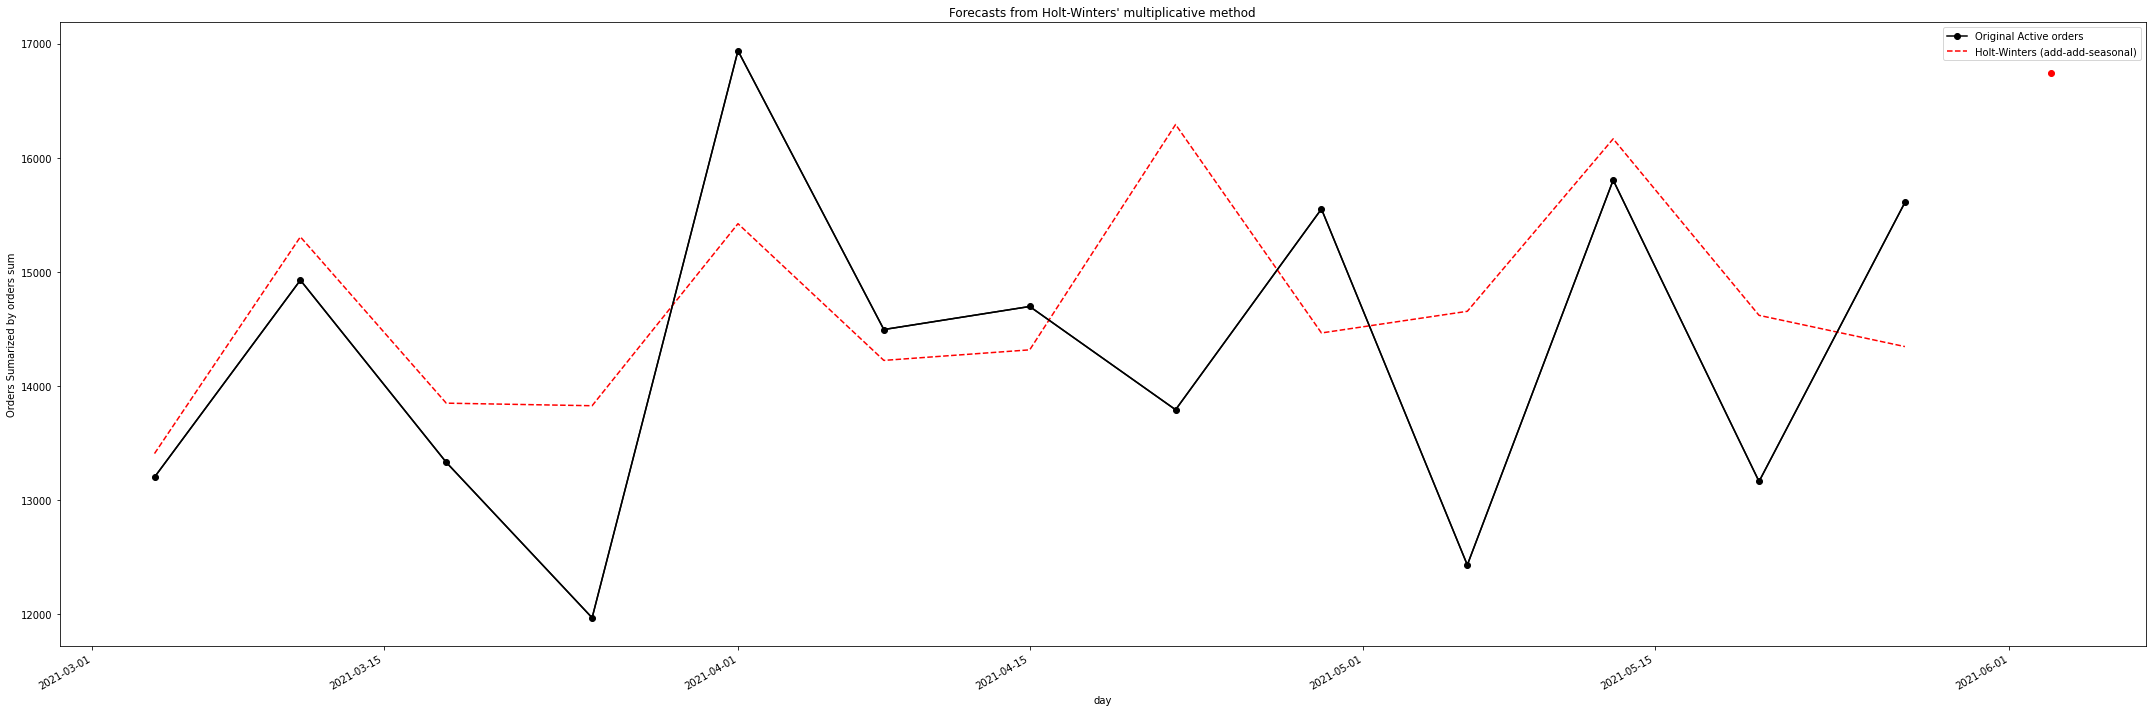

------ ANALYSIS RESULT W FORECAST ------
 
Total Original Active orders day 2021-05-27 hours [13] :  15608
Aprox Original Active orders forecasted for period : [13] :  14344
Total Oder loss aprox : No order loss
Total de ordernes activas Full day: 192662
Average  active  orders :  14284
------------------------------------------------------------------
Calculated Downtime for day :  0 %
Calculated Uptime for day :  100 %
 
------ ANALYSIS RESULT W AVG ------
 
Total Original Active orders day 2021-05-27 hours [13] :  15608
Aprox mean 14284
Total Oder loss aprox vs mean: No order loss
Total de ordernes activas Full day: 192662
Average  active  orders :  14284
------------------------------------------------------------------
Calculated Downtime for day :  0 %
Calculated Uptime for day :  100 %
 
------ ANALYSIS RESULT SAME DAY PREVIOUS MONTH ------
 
Total Original Active orders day 2021-05-27 hours [13] :  15608
Total Original Active orders previous dayand month, hours [13] :  15551
To

In [7]:
import datetime
from datetime import date, timedelta
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing


if (hour_ini==hour_fin):
    hours = [hour_ini]
else:
    hours = list(range(hour_ini, hour_fin)) 
fday_hours = list(range(0,24))

class CalculateDowntime():

   def Title (self, ccountry):
       print('\033[1m' + "---------------------------------------- DOWNTIME REPORT",ccountry.upper() , idate," ----------------------------------------"+'\033[0m')
       print(" ")
       print("-- DATA FOR ANALYSIS --")
       print(" ")
       print("Vertical analized:",vertical)
       print("Country:",ccountry)
       print("Day of issue :", idate)
       print("Issue type:", calc_type )
       print("Analized hours : ", hours)
       print("Total hours day: 24")
       print("Forecasted days:", forecast_days)
       print("Period of analisis Months:", period)



   def Calculate(self, df, fday_hours):
       # Filtro los datos de las no canceladas para el dia completo issue_date
       #result_total_orders_day = df.query('level_1 == "non_cancelled" and hour in @fday_hours ')
       result_total_orders_day = df.query('hour in @fday_hours')
       if calc_type == "active" :
           label="Original Active orders"
           if vertical != "all":
              result = df.query('level_1 == "non_cancelled" and hour in @hours and vertical in @vertical')      
           else:
              # Filtro los datos de las no canceladas para el periodo hours issue_date
              result = df.query('level_1 == "non_cancelled" and hour in @hours ') 
       else:
           label="Original Canceled orders"
           if vertical != "all":
              result = df.query('level_1 != "non_cancelled" and hour in @hours and vertical in @vertical')      
           else:
              # Filtro los datos de las canceladas para el periodo hours issue_date
              result = df.query('level_1 != "non_cancelled" and hour in @hours ')

       print(" ")
       print("-- FORECAST GRAPH --")
       print("Using Seasonal: ", seasonal)
       print("Seasonal Periods: ", s_periods )
       print("Forecast days: ", forecast_days)
       print(" ")

       # Se arma la tabla para el periodo 24hs del dia issue date 
       fday_orders = result_total_orders_day.set_index('day')
       fday_neworders = fday_orders.groupby('day')['orders'].sum()
   
       # Se arma la tabla para el periodo hours del dia issue date 
       orders = result.set_index('day')
       neworders = orders.groupby('day')['orders'].sum()
       np.asarray(neworders)

       %matplotlib inline

       if (seasonal==False) :
           fit1 = ExponentialSmoothing(neworders, seasonal_periods=s_periods, trend="mul", seasonal=None, damped=True).fit(optimized=True,use_boxcox=False)
       else:
           fit1 = ExponentialSmoothing(neworders, seasonal_periods=s_periods, trend="mul", seasonal='add', damped=True).fit(optimized=True,use_boxcox=False)
   
       ax = neworders.plot(figsize=(30,10), marker='o', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
       ax.set_ylabel("Orders Sumarized by orders sum")
       ax.set_xlabel("Days")

       from matplotlib.dates import AutoDateFormatter, AutoDateLocator

       xtick_locator = AutoDateLocator()
       xtick_formatter = AutoDateFormatter(xtick_locator)

       ax.xaxis.set_major_locator(xtick_locator)
       ax.xaxis.set_major_formatter(xtick_formatter)
   
       fit1.fittedvalues.plot(ax=ax, style='--', color='red')
       neworders.rename(label).plot(figsize=(30,10),kind='line', color='black', legend=True);
   
       fit1.forecast(forecast_days).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)
   
       newdf = pd.DataFrame(np.c_[neworders, fit1.level, fit1.slope, fit1.season, fit1.fittedvalues],columns=[r'y_t',r'l_t',r'b_t',r's_t',r'hat{y}'],index=neworders.index)
       newdf.append(fit1.forecast(forecast_days).rename(r'$\hat{y}_t$').to_frame(), sort=True)
   
       plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
       plt.tight_layout()
       plt.show()

  #     try:  
           # Saco el dato del forecasted para el dia del issue_date en el periodo hours
       fday= int(newdf['hat{y}'][-1])
           # Saco el dato del total de ordenes del issue_date para el periodo hours y el mismo dia mes anterior
       # IDAY OJO ACA HAY QUE REMOVER O AGREGAR 
       # -----------------------------------------
       iday = int(neworders[-1])
       # -----------------------------------------
       pday = int(neworders[-2])
       pmonth = int(neworders[-5])
           # Saco el dato del total de ordenes activas del issue date en 24 horas  
       tday_orders_sum = int(fday_neworders[-2])
           #Calculo el Promedio de canceladas historico sacando el ultimo dia mal calculado, y el di del issue
       co_avg = int(newdf['y_t'][:-2].mean())

       avg_days = newdf['y_t']
       mean_week =  int(newdf['y_t'][:-2].mean())      
    
       # Calculo el total de ordenes perdidas del dia, para ambos tipos de issue canceladas y no canceladas
       if calc_type == "active" :
           if (fday > iday) or (mean_week > iday) or (pday > iday):
               if (fday > iday):
                   # Saco el aprox de order loss para el issue_date en el periodo hours 
                   order_loss_aprox_mean = int(mean_week - iday)
                   order_loss_aprox = int(fday - iday)     
                   downtime = float(( order_loss_aprox/tday_orders_sum)*100)
               else:
                    downtime = 0
                    order_loss_aprox = "No order loss"
               if (mean_week > iday):
                   order_loss_aprox_mean = int(mean_week-iday)
                   downtime_mean = float(( order_loss_aprox_mean/tday_orders_sum)*100)
               else:
                   downtime_mean = 0
                   order_loss_aprox_mean = 0
               if (pday > iday):
                   downtime_pday = float(( int(pday-iday)/tday_orders_sum)*100)
                   pday_loss = int(pday-iday)
               else:
                   downtime_pday = 0 
                   pday_loss = 0
               if (pmonth > iday):
                   downtime_pmonth = float(( int(pmonth-iday)/tday_orders_sum)*100)
                   pmonth_loss = int(pmonth-iday)
               else:
                   downtime_pmonth = 0 
                   pmonth_loss = 0       
           else:
               order_loss_aprox_mean = "No order loss"
               pday_loss = 0
               downtime_mean = 0
               downtime_pday = 0
               downtime_pmonth = 0
               pmonth_loss = 0
               order_loss_aprox = "No order loss"
               downtime = 0
            
       # Para las canceladas :
       else:
           if (iday >= fday) or (iday >= co_avg) or (iday > pday):
               if (iday >= fday):
               # Saco el aprox de order loss para el issue_date en el periodo hours 
               # Calculo downtime en base al aproximado de ordenes perdidas vs el total de ordenes del dia 
                   order_loss_aprox = int(iday - fday)
                   downtime = float(( order_loss_aprox/tday_orders_sum)*100) 
               else:
                   order_loss_aprox = "No order loss"
                   downtime = 0
               if (iday >= co_avg):
                   order_loss_aprox_mean = int(iday - co_avg)
                   downtime_mean = float(( order_loss_aprox_mean/tday_orders_sum)*100) 
               else:
                   order_loss_aprox_mean = "No order loss"
                   downtime_mean = 0
               if (iday > pmonth):
                   downtime_pmonth = float(( int(iday-pmonth)/tday_orders_sum)*100)
                   pmonth_loss = int(iday-pmonth)
               else:
                   downtime_pmonth = 0
                   pmonth_loss = 0
               if (iday > pday):
                   downtime_pday = float(( int(iday-pday)/tday_orders_sum)*100)
                   pday_loss = int(iday-pday)
               else:
                   downtime_pday = 0
                   pday_loss = 0
           else:
               order_loss_aprox_mean = "No order loss"
               pday_loss = 0
               pmonth_loss = 0
               downtime_mean = 0
               downtime_pday = 0
               downtime_pmonth = 0
               order_loss_aprox = "No order loss"
               downtime = 0
       
        
       print("------ ANALYSIS RESULT W FORECAST ------")
       print(" ")
       print("Total",label, "day", idate, "hours",hours, ": ", iday ) 
       print("Aprox", label, "forecasted for period :" , hours ,": ",fday)
       print("Total Oder loss aprox :", order_loss_aprox)
       print("Total de ordernes activas Full day:", tday_orders_sum)
       print("Average ",calc_type, " orders : ", co_avg)
       print("------------------------------------------------------------------")
       print('\033[1m' + "Calculated Downtime for day : ", round(downtime, 2), "%")
       print('\033[1m' + "Calculated Uptime for day : ", 100-round(downtime, 2), "%"+'\033[0m')
       print(" ")
       print("------ ANALYSIS RESULT W AVG ------")
       print(" ")
       print("Total",label, "day", idate, "hours",hours, ": ", iday ) 
       print("Aprox mean", mean_week)
       print("Total Oder loss aprox vs mean:", order_loss_aprox_mean  )
       print("Total de ordernes activas Full day:", tday_orders_sum)
       print("Average ",calc_type, " orders : ", co_avg)
       print("------------------------------------------------------------------")
       print('\033[1m' + "Calculated Downtime for day : ", round(downtime_mean, 2), "%")
       print('\033[1m' + "Calculated Uptime for day : ", 100-round(downtime_mean, 2), "%"+'\033[0m')
       print(" ")
       print("------ ANALYSIS RESULT SAME DAY PREVIOUS MONTH ------")
       print(" ")
       print("Total",label, "day", idate, "hours",hours, ": ", iday ) 
       print("Total",label, "previous dayand month, hours",hours, ": ",pmonth ) 
       print("Total Oder loss aprox vs mean:",   pmonth_loss )
       print("Total de ordernes activas Full day:", tday_orders_sum)
       print("------------------------------------------------------------------")
       print('\033[1m' + "Calculated Downtime for day : ", round(downtime_pmonth, 2), "%")
       print('\033[1m' + "Calculated Uptime for day : ", 100-round(downtime_pmonth, 2), "%"+'\033[0m')
       print(" ")
       print("------ ANALYSIS RESULT SAME DAY PREVIOUS WEEK ------")
       print(" ")
       print("Total",label, "day", idate, "hours",hours, ": ", iday ) 
       print("Total",label, "previous dayand month, hours",hours, ": ",pday ) 
       print("Total Oder loss aprox vs mean:",   pday_loss )
       print("Total de ordernes activas Full day:", tday_orders_sum)
       print("------------------------------------------------------------------")
       print('\033[1m' + "Calculated Downtime for day : ", round(downtime_pday, 2), "%")
       print('\033[1m' + "Calculated Uptime for day : ", 100-round(downtime_pday, 2), "%"+'\033[0m')
       print(" ")
       print("------ Data Table w forecast Holt and Winters ------")
       print(" ")
       print(newdf)
       print(" ")
       return  'End of Analisis'

for report in clist:
    calc = CalculateDowntime()
    calc.Title(report["country"])
    calc.Calculate(report["data"], fday_hours)

In [8]:
import datetime
from datetime import date, timedelta
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing


if (hour_ini==hour_fin):
    hours = [hour_ini]
else:
    hours = list(range(hour_ini, hour_fin)) 
fday_hours = list(range(0,24))

class CalculateDowntime():

   def Title (self, ccountry):
       print('\033[1m' + "---------------------------------------- DOWNTIME REPORT",ccountry.upper() , idate," ----------------------------------------"+'\033[0m')
       print(" ")
       print("-- DATA FOR ANALYSIS --")
       print(" ")
       print("Vertical analized:",vertical)
       print("Country:",ccountry)
       print("Day of issue :", idate)
       print("Issue type:", calc_type )
       print("Analized hours : ", hours)
       print("Total hours day: 24")
       print("Forecasted days:", forecast_days)
       print("Period of analisis Months:", period)



   def Calculate(self, df, fday_hours):
       # Filtro los datos de las no canceladas para el dia completo issue_date
       #result_total_orders_day = df.query('level_1 == "non_cancelled" and hour in @fday_hours ')
       result_total_orders_day = df.query('hour in @fday_hours')
       """if calc_type == "active" :
           label="Original Active orders"
           if vertical != "all":
              result = df.query('level_1 == "non_cancelled" and hour in @hours and vertical in @vertical')      
           else:
              # Filtro los datos de las no canceladas para el periodo hours issue_date
              result = df.query('level_1 == "non_cancelled" and hour in @hours ') 
       else:
           label="Original Canceled orders"
           if vertical != "all":
              result = df.query('level_1 != "non_cancelled" and hour in @hours and vertical in @vertical')      
           else:
              # Filtro los datos de las canceladas para el periodo hours issue_date
              result = df.query('level_1 != "non_cancelled" and hour in @hours ')

       print(" ")
       print("-- FORECAST GRAPH --")
       print("Using Seasonal: ", seasonal)
       print("Seasonal Periods: ", s_periods )
       print("Forecast days: ", forecast_days)
       print(" ")

       # Se arma la tabla para el periodo 24hs del dia issue date 
       fday_orders = result_total_orders_day.set_index('day')
       fday_neworders = fday_orders.groupby('day')['orders'].sum()
   
       # Se arma la tabla para el periodo hours del dia issue date 
       orders = result.set_index('day')
       neworders = orders.groupby('day')['orders'].sum()
       np.asarray(neworders)

       %matplotlib inline

       if (seasonal==False) :
           fit1 = ExponentialSmoothing(neworders, seasonal_periods=s_periods, trend="mul", seasonal=None, damped=True).fit(optimized=True,use_boxcox=False)
       else:
           fit1 = ExponentialSmoothing(neworders, seasonal_periods=s_periods, trend="mul", seasonal='add', damped=True).fit(optimized=True,use_boxcox=False)
   
       ax = neworders.plot(figsize=(30,10), marker='o', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
       ax.set_ylabel("Orders Sumarized by orders sum")
       ax.set_xlabel("Days")

       from matplotlib.dates import AutoDateFormatter, AutoDateLocator

       xtick_locator = AutoDateLocator()
       xtick_formatter = AutoDateFormatter(xtick_locator)

       ax.xaxis.set_major_locator(xtick_locator)
       ax.xaxis.set_major_formatter(xtick_formatter)
   
       fit1.fittedvalues.plot(ax=ax, style='--', color='red')
       neworders.rename(label).plot(figsize=(30,10),kind='line', color='black', legend=True);
   
       fit1.forecast(forecast_days).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)
   
       newdf = pd.DataFrame(np.c_[neworders, fit1.level, fit1.slope, fit1.season, fit1.fittedvalues],columns=[r'y_t',r'l_t',r'b_t',r's_t',r'hat{y}'],index=neworders.index)
       newdf.append(fit1.forecast(forecast_days).rename(r'$\hat{y}_t$').to_frame(), sort=True)
   
       plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
       plt.tight_layout()
       plt.show()

  #     try:  
           # Saco el dato del forecasted para el dia del issue_date en el periodo hours
       fday= int(newdf['hat{y}'][-1])
           # Saco el dato del total de ordenes del issue_date para el periodo hours y el mismo dia mes anterior
       # IDAY OJO ACA HAY QUE REMOVER O AGREGAR 
       # -----------------------------------------
       iday = int(neworders[-1])
       # -----------------------------------------
       pday = int(neworders[-2])
       pmonth = int(neworders[-5])
           # Saco el dato del total de ordenes activas del issue date en 24 horas  
       tday_orders_sum = int(fday_neworders[-2])
           #Calculo el Promedio de canceladas historico sacando el ultimo dia mal calculado, y el di del issue
       co_avg = int(newdf['y_t'][:-2].mean())

       avg_days = newdf['y_t']
       mean_week =  int(newdf['y_t'][:-2].mean())      
    
       # Calculo el total de ordenes perdidas del dia, para ambos tipos de issue canceladas y no canceladas
       if calc_type == "active" :
           if (fday > iday) or (mean_week > iday) or (pday > iday):
               if (fday > iday):
                   # Saco el aprox de order loss para el issue_date en el periodo hours 
                   order_loss_aprox_mean = int(mean_week - iday)
                   order_loss_aprox = int(fday - iday)     
                   downtime = float(( order_loss_aprox/tday_orders_sum)*100)
               else:
                    downtime = 0
                    order_loss_aprox = "No order loss"
               if (mean_week > iday):
                   order_loss_aprox_mean = int(mean_week-iday)
                   downtime_mean = float(( order_loss_aprox_mean/tday_orders_sum)*100)
               else:
                   downtime_mean = 0
                   order_loss_aprox_mean = 0
               if (pday > iday):
                   downtime_pday = float(( int(pday-iday)/tday_orders_sum)*100)
                   pday_loss = int(pday-iday)
               else:
                   downtime_pday = 0 
                   pday_loss = 0
               if (pmonth > iday):
                   downtime_pmonth = float(( int(pmonth-iday)/tday_orders_sum)*100)
                   pmonth_loss = int(pmonth-iday)
               else:
                   downtime_pmonth = 0 
                   pmonth_loss = 0       
           else:
               order_loss_aprox_mean = "No order loss"
               pday_loss = 0
               downtime_mean = 0
               downtime_pday = 0
               downtime_pmonth = 0
               pmonth_loss = 0
               order_loss_aprox = "No order loss"
               downtime = 0
            
       # Para las canceladas :
       else:
           if (iday >= fday) or (iday >= co_avg) or (iday > pday):
               if (iday >= fday):
               # Saco el aprox de order loss para el issue_date en el periodo hours 
               # Calculo downtime en base al aproximado de ordenes perdidas vs el total de ordenes del dia 
                   order_loss_aprox = int(iday - fday)
                   downtime = float(( order_loss_aprox/tday_orders_sum)*100) 
               else:
                   order_loss_aprox = "No order loss"
                   downtime = 0
               if (iday >= co_avg):
                   order_loss_aprox_mean = int(iday - co_avg)
                   downtime_mean = float(( order_loss_aprox_mean/tday_orders_sum)*100) 
               else:
                   order_loss_aprox_mean = "No order loss"
                   downtime_mean = 0
               if (iday > pmonth):
                   downtime_pmonth = float(( int(iday-pmonth)/tday_orders_sum)*100)
                   pmonth_loss = int(iday-pmonth)
               else:
                   downtime_pmonth = 0
                   pmonth_loss = 0
               if (iday > pday):
                   downtime_pday = float(( int(iday-pday)/tday_orders_sum)*100)
                   pday_loss = int(iday-pday)
               else:
                   downtime_pday = 0
                   pday_loss = 0
           else:
               order_loss_aprox_mean = "No order loss"
               pday_loss = 0
               pmonth_loss = 0
               downtime_mean = 0
               downtime_pday = 0
               downtime_pmonth = 0
               order_loss_aprox = "No order loss"
               downtime = 0
       
        
       print("------ ANALYSIS RESULT W FORECAST ------")
       print(" ")
       print("Total",label, "day", idate, "hours",hours, ": ", iday ) 
       print("Aprox", label, "forecasted for period :" , hours ,": ",fday)
       print("Total Oder loss aprox :", order_loss_aprox)
       print("Total de ordernes activas Full day:", tday_orders_sum)
       print("Average ",calc_type, " orders : ", co_avg)
       print("------------------------------------------------------------------")
       print('\033[1m' + "Calculated Downtime for day : ", round(downtime, 2), "%")
       print('\033[1m' + "Calculated Uptime for day : ", 100-round(downtime, 2), "%"+'\033[0m')
       print(" ")
       print("------ ANALYSIS RESULT W AVG ------")
       print(" ")
       print("Total",label, "day", idate, "hours",hours, ": ", iday ) 
       print("Aprox mean", mean_week)
       print("Total Oder loss aprox vs mean:", order_loss_aprox_mean  )
       print("Total de ordernes activas Full day:", tday_orders_sum)
       print("Average ",calc_type, " orders : ", co_avg)
       print("------------------------------------------------------------------")
       print('\033[1m' + "Calculated Downtime for day : ", round(downtime_mean, 2), "%")
       print('\033[1m' + "Calculated Uptime for day : ", 100-round(downtime_mean, 2), "%"+'\033[0m')
       print(" ")
       print("------ ANALYSIS RESULT SAME DAY PREVIOUS MONTH ------")
       print(" ")
       print("Total",label, "day", idate, "hours",hours, ": ", iday ) 
       print("Total",label, "previous dayand month, hours",hours, ": ",pmonth ) 
       print("Total Oder loss aprox vs mean:",   pmonth_loss )
       print("Total de ordernes activas Full day:", tday_orders_sum)
       print("------------------------------------------------------------------")
       print('\033[1m' + "Calculated Downtime for day : ", round(downtime_pmonth, 2), "%")
       print('\033[1m' + "Calculated Uptime for day : ", 100-round(downtime_pmonth, 2), "%"+'\033[0m')
       print(" ")
       print("------ ANALYSIS RESULT SAME DAY PREVIOUS WEEK ------")
       print(" ")
       print("Total",label, "day", idate, "hours",hours, ": ", iday ) 
       print("Total",label, "previous dayand month, hours",hours, ": ",pday ) 
       print("Total Oder loss aprox vs mean:",   pday_loss )
       print("Total de ordernes activas Full day:", tday_orders_sum)
       print("------------------------------------------------------------------")
       print('\033[1m' + "Calculated Downtime for day : ", round(downtime_pday, 2), "%")
       print('\033[1m' + "Calculated Uptime for day : ", 100-round(downtime_pday, 2), "%"+'\033[0m')
       print(" ")
       print("------ Data Table w forecast Holt and Winters ------")
       print(" ")
       print(newdf)
       print(" ")
       return  'End of Analisis'"""

for report in clist:
    calc = CalculateDowntime()
    calc.Title(report["country"])
    calc.Calculate(report["data"], fday_hours)

---------------------------------------- DOWNTIME REPORT CO 2021-05-27  ----------------------------------------
 
-- DATA FOR ANALYSIS --
 
Vertical analized: all
Country: CO
Day of issue : 2021-05-27
Issue type: active
Analized hours :  [13]
Total hours day: 24
Forecasted days: 1
Period of analisis Months: 3
